Visualization for 4-28-investigation shows that our batch produce way too similar result in the last layer. (if we are going to do K-NN, they are super close to each other). 

I don't think re-training last few layers would help. Maybe I'm wrong. 

Is there a way that directly take advantage of output of each intermediate blocks. And aggreagate them for fine-grained classification. 

"Deep Layer Aggregation" you say... 

Another name is self attention. 

In [1]:
# from AttentionModule import Conv2d_Attn

import torch
from torch import nn
from torchvision import models, datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import re
import numpy as np

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [3]:
res = models.resnet18(pretrained=True)

In [4]:
blks = list(res.children())

In [5]:
batch_size = 512
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [transforms.ToTensor(),
     normalize])

trainset = torchvision.datasets.ImageFolder(root='../data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [6]:
batch, labels = next(iter(trainloader))

In [7]:
res = res.eval().cuda()

In [22]:
outs = []
out = Variable(batch).cuda()

RuntimeError: cuda runtime error (2) : out of memory at /pytorch/torch/lib/THC/generic/THCStorage.cu:58

In [23]:
def linear_pre_hook(out):
    return out.view(out.size(0), -1)

In [21]:
pre_pool_var = None
for i, layer in enumerate(blks):
    print(type(layer))
    if isinstance(layer, torch.nn.modules.linear.Linear):
        out = out.view(out.size(0), -1)
    out = layer(out)
    if i == 7:
        pre_pool_var = out
    outs.append(out)

<class 'torch.nn.modules.conv.Conv2d'>


ValueError: Expected 4D tensor as input, got 2D tensor instead.

In [12]:
im = pre_pool_var.data.squeeze().cpu().numpy()

In [15]:
im = im.reshape(512, -1)

In [16]:
im.shape

(512, 25088)

Text(0,0.5,'Image #')

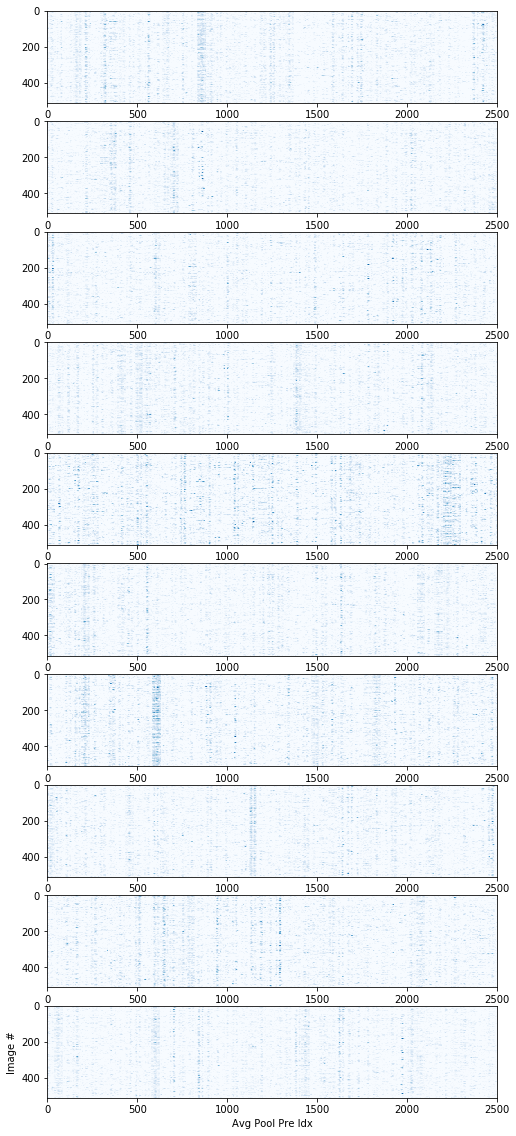

In [24]:
plt.figure(figsize=(20,20))
for i in range(10):
    start, end = i*2500, (i+1)*2500
    to_show = im[:, start:end]
    plt.subplot(10,1,i+1)
    plt.imshow(to_show, cmap='Blues')
plt.xlabel('Avg Pool Pre Idx')
plt.ylabel('Image #')

Conclusion: at last blk output, the features are diverge enough

In [57]:
list(map(lambda x:x.size(), outs))

[torch.Size([32, 64, 112, 112]),
 torch.Size([32, 64, 112, 112]),
 torch.Size([32, 64, 112, 112]),
 torch.Size([32, 64, 56, 56]),
 torch.Size([32, 64, 56, 56]),
 torch.Size([32, 128, 28, 28]),
 torch.Size([32, 256, 14, 14]),
 torch.Size([32, 512, 7, 7]),
 torch.Size([32, 512, 1, 1]),
 torch.Size([32, 1000])]

In [59]:
blks

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
 ),